In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Laden der Daten (angenommen bereits importiert)
df = pd.read_csv('../data/processed/interest_rates_on_new_loans_by_product/snb-data-zikreddet-de-all-20250422_0900.csv', sep=';', quotechar='"')
# Pivotieren der Daten, damit jede Kreditart eine eigene Spalte wird
df_pivot = df.pivot(index='Date', columns='D0', values='Value').reset_index()

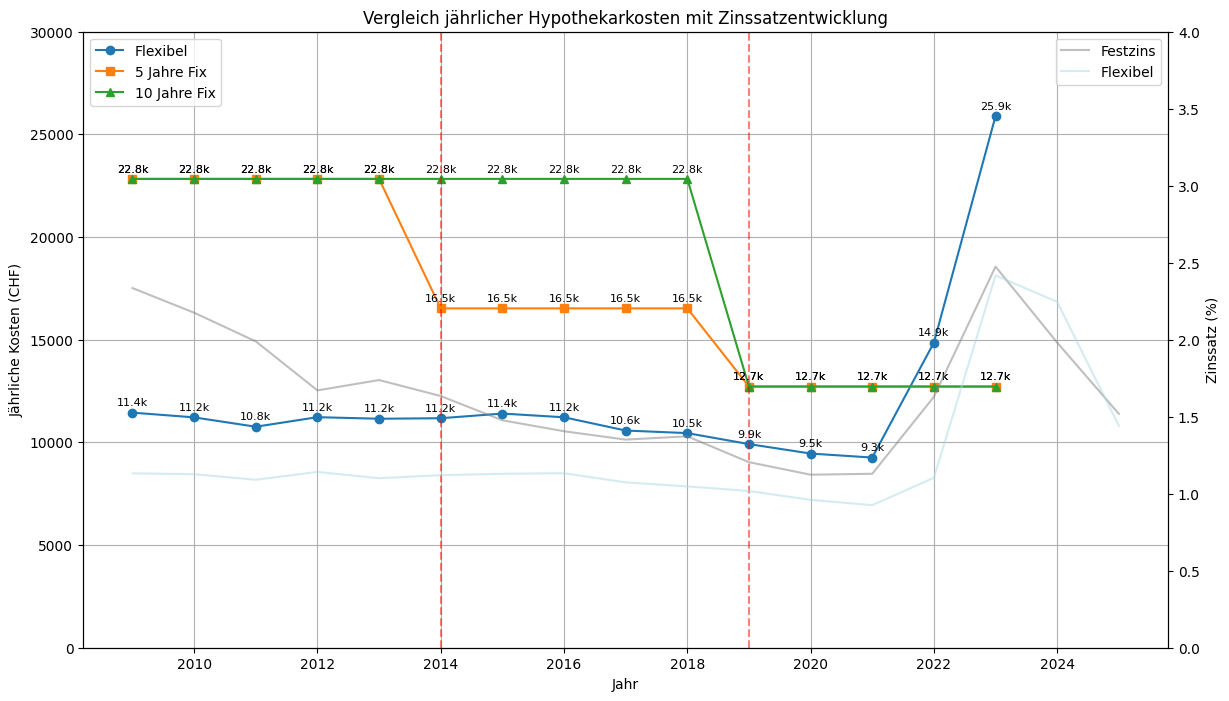

In [2]:
# Beispielwerte fuer die Berechnungen
P = 1000000  # Kreditsumme in CHF
laufzeit_jahre = 15
n = laufzeit_jahre * 12  # Monate

# Funktion zur Berechnung der jaehrlichen Zinskosten
def berechne_jaehrliche_kosten(P, zins):
    return P * zins

# Zuweisung der Zinssaetze
df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])
df_pivot['Jahr'] = df_pivot['Date'].dt.year
zins_fh = df_pivot['FH'] / 100  # Festverzinsliche Hypothek
zins_mbb = df_pivot['MBB'] / 100  # Mit Basisbindung (flexibel)

# Vorbereitung der Szenarien
jahre = np.arange(2009, 2009 + laufzeit_jahre)
kosten_flex = []
kosten_fix5 = []
kosten_fix10 = []

# Zinssaetze zu Beginn und bei Neuverhandlungen
zins_fix5_start = zins_fh.iloc[0]
zins_fix5_neu1 = zins_fh.iloc[60] if len(zins_fh) > 60 else zins_fh.iloc[-1]
zins_fix5_neu2 = zins_fh.iloc[120] if len(zins_fh) > 120 else zins_fh.iloc[-1]
zins_fix10_start = zins_fh.iloc[0]
zins_fix10_neu = zins_fh.iloc[120] if len(zins_fh) > 120 else zins_fh.iloc[-1]

# Flexibel: jaehrliche Zinskosten anhand monatlich veraenderter Zinssaetze
for jahr in range(laufzeit_jahre):
    start_idx = jahr * 12
    end_idx = start_idx + 12
    jahr_zinsen = []
    for idx in range(start_idx, min(end_idx, len(zins_mbb))):
        jahr_zinsen.append(berechne_jaehrliche_kosten(P, zins_mbb.iloc[idx]))
    kosten_flex.append(np.mean(jahr_zinsen))

# Fix 5 Jahre: Zins bleibt 5 Jahre gleich
for jahr in range(laufzeit_jahre):
    if jahr < 5:
        zins = zins_fix5_start
    elif jahr < 10:
        zins = zins_fix5_neu1
    else:
        zins = zins_fix5_neu2
    kosten_fix5.append(berechne_jaehrliche_kosten(P, zins))

# Fix 10 Jahre: Zins bleibt 10 Jahre gleich
for jahr in range(laufzeit_jahre):
    if jahr < 10:
        zins = zins_fix10_start
    else:
        zins = zins_fix10_neu
    kosten_fix10.append(berechne_jaehrliche_kosten(P, zins))

# Jahresdurchschnitt der Zinssaetze
zins_fh_jahr = df_pivot.groupby('Jahr')['FH'].mean() / 100
zins_mbb_jahr = df_pivot.groupby('Jahr')['MBB'].mean() / 100

# Plot: Kostenvergleich mit zweiter Achse fuer Zinssaetze
fig, ax1 = plt.subplots(figsize=(14,8))

# Primäre Achse - jährliche Kosten
ax1.plot(jahre, kosten_flex, label='Flexibel', marker='o')
ax1.plot(jahre, kosten_fix5, label='5 Jahre Fix', marker='s')
ax1.plot(jahre, kosten_fix10, label='10 Jahre Fix', marker='^')
ax1.set_xlabel('Jahr')
ax1.set_ylabel('Jährliche Kosten (CHF)')
ax1.set_ylim(0, 30000)
ax1.grid()
ax1.legend(loc='upper left')

# Werte als Text bei den Punkten
for i in range(len(jahre)):
    ax1.annotate(f"{kosten_flex[i]/1000:.1f}k", (jahre[i], kosten_flex[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
    ax1.annotate(f"{kosten_fix5[i]/1000:.1f}k", (jahre[i], kosten_fix5[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
    ax1.annotate(f"{kosten_fix10[i]/1000:.1f}k", (jahre[i], kosten_fix10[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

# Highlight der Tilgungsjahre
highlight_years = [2014, 2019]
for year in highlight_years:
    plt.axvline(x=year, color='red', linestyle='--', alpha=0.5)

# Sekundäre Achse - Zinssaetze (auf gleiche Jahre gemappt)
ax2 = ax1.twinx()
ax2.plot(zins_fh_jahr.index, zins_fh_jahr * 100, color='grey', alpha=0.5, label='Festzins')
ax2.plot(zins_mbb_jahr.index, zins_mbb_jahr * 100, color='lightblue', alpha=0.5, label='Flexibel')
ax2.set_ylabel('Zinssatz (%)')
ax2.set_ylim(0, 4)
ax2.legend(loc='upper right')

plt.title('Vergleich jährlicher Hypothekarkosten mit Zinssatzentwicklung')
plt.show()

Tilgung je Jahr nach Hypothekenmodell:
 Jahr  Tilgung Flexibel (CHF)  Tilgung 5 Jahre Fix (CHF)  Tilgung 10 Jahre Fix (CHF)
 2010                 15000.0                        0.0                         0.0
 2011                 15000.0                        0.0                         0.0
 2012                 15000.0                        0.0                         0.0
 2013                 15000.0                        0.0                         0.0
 2014                 15000.0                    50000.0                         0.0
 2015                 15000.0                        0.0                         0.0
 2016                 15000.0                        0.0                         0.0
 2017                 15000.0                        0.0                         0.0
 2018                 15000.0                        0.0                         0.0
 2019                 15000.0                    50000.0                    100000.0
 2020                 1500

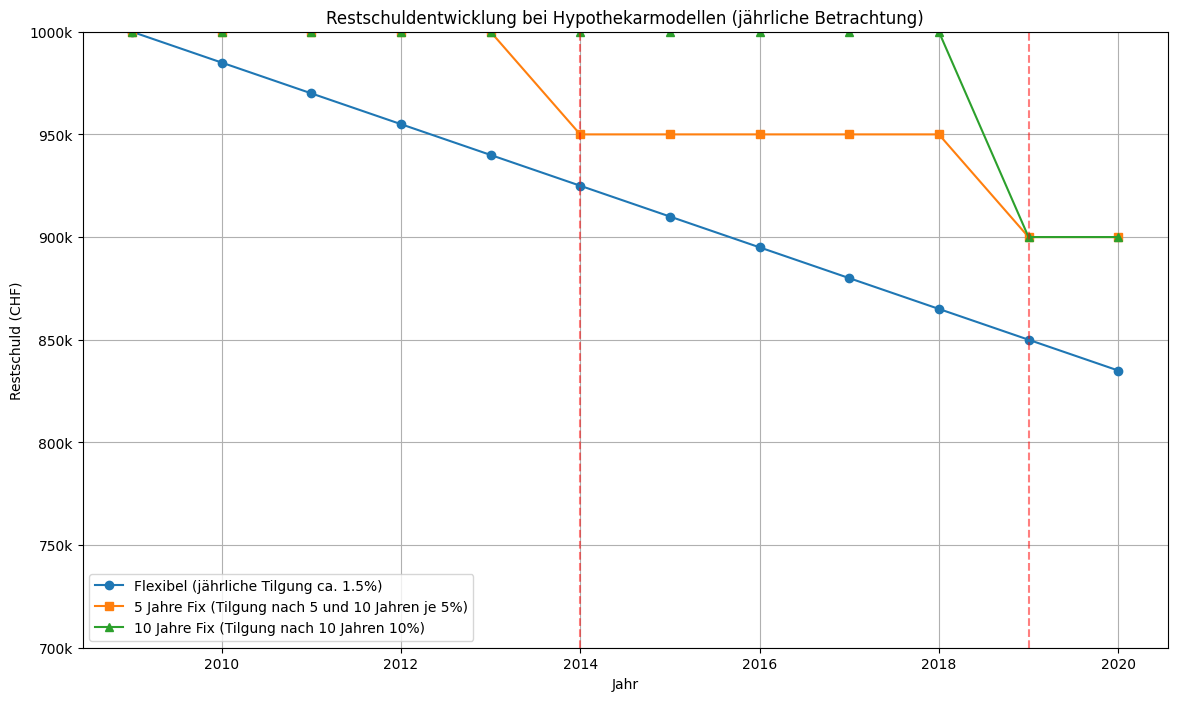

In [3]:
# Annahmen
P = 1000000  # Kreditsumme in CHF
laufzeit_jahre = 11  # angepasst auf 11 Jahre
n = laufzeit_jahre * 12  # Monate

# Funktion zur Berechnung der monatlichen Rate (nur Zinszahlung)
def berechne_zinszahlung(P, r):
    return P * r

# Tilgungsverlauf neu aufgebaut
saldo_flex = [P]
saldo_fix5 = [P]
saldo_fix10 = [P]

# Flexibel: Zinszahlungen plus ca. 1.5% p.a. Tilgung
saldo = P
for idx in range(n):
    r = zins_mbb.iloc[min(idx, len(zins_mbb)-1)] / 12
    tilgung_monatlich = (P * 0.015) / 12  # 1.5% p.a.
    saldo -= tilgung_monatlich
    saldo_flex.append(max(saldo, 0))

# 5 Jahre Fix: Tilgung nur in Jahr 5 (Monat 59) und Jahr 10 (Monat 119) (5% jeweils)
saldo = P
zins_fix5_1 = zins_fh.iloc[0] / 12
zins_fix5_2 = zins_fh.iloc[60] / 12 if len(zins_fh) > 60 else zins_fh.iloc[-1] / 12
for idx in range(n):
    if idx == 59:
        saldo -= P * 0.05  # Tilgung 5% nach 5 Jahren
    if idx == 119:
        saldo -= P * 0.05  # Tilgung 5% nach weiteren 5 Jahren
    saldo_fix5.append(max(saldo, 0))

# 10 Jahre Fix: Tilgung nur in Jahr 10 (Monat 119) (10%)
saldo = P
zins_fix10 = zins_fh.iloc[0] / 12
for idx in range(n):
    if idx == 119:
        saldo -= P * 0.10  # Tilgung 10% nach 10 Jahren
    saldo_fix10.append(max(saldo, 0))

# Umrechnung auf jaehrliche Werte fuer Tilgung
jahre = np.arange(0, 12, 1)
saldo_flex_jahr = [saldo_flex[min(i*12, len(saldo_flex)-1)] for i in jahre]
saldo_fix5_jahr = [saldo_fix5[min(i*12, len(saldo_fix5)-1)] for i in jahre]
saldo_fix10_jahr = [saldo_fix10[min(i*12, len(saldo_fix10)-1)] for i in jahre]

# Berechnung der jaehrlichen Tilgungsbetraege
tilgung_flex = [saldo_flex_jahr[i-1] - saldo_flex_jahr[i] for i in range(1, len(saldo_flex_jahr))]
tilgung_fix5 = [saldo_fix5_jahr[i-1] - saldo_fix5_jahr[i] for i in range(1, len(saldo_fix5_jahr))]
tilgung_fix10 = [saldo_fix10_jahr[i-1] - saldo_fix10_jahr[i] for i in range(1, len(saldo_fix10_jahr))]

# Tabelle der Tilgungsbetraege erstellen
tilgung_df = pd.DataFrame({
    'Jahr': jahre[1:] + 2009,
    'Tilgung Flexibel (CHF)': tilgung_flex,
    'Tilgung 5 Jahre Fix (CHF)': tilgung_fix5,
    'Tilgung 10 Jahre Fix (CHF)': tilgung_fix10
})

# Ausgabe der Tilgungstabelle
print("Tilgung je Jahr nach Hypothekenmodell:")
print(tilgung_df.to_string(index=False))

# Erklaerungstext
print("\nErklärung: Die jährlichen Tilgungsbeträge wurden angepasst. Bei flexiblen Hypotheken wird etwa 1.5% p.a. getilgt, bei Fixhypotheken erfolgen Tilgungen von 5% nach 5 und 10 Jahren (bei 5-Jahresmodell) bzw. 10% nach 10 Jahren (bei 10-Jahresmodell).")

# Plot Tilgungsverlauf ueber 11 Jahre (jaehrlich)
plt.figure(figsize=(14,8))
plt.plot(jahre + 2009, saldo_flex_jahr, marker='o', label='Flexibel (jährliche Tilgung ca. 1.5%)')
plt.plot(jahre + 2009, saldo_fix5_jahr, marker='s', label='5 Jahre Fix (Tilgung nach 5 und 10 Jahren je 5%)')
plt.plot(jahre + 2009, saldo_fix10_jahr, marker='^', label='10 Jahre Fix (Tilgung nach 10 Jahren 10%)')

# Highlight der Tilgungsjahre
highlight_years = [2014, 2019]
for year in highlight_years:
    plt.axvline(x=year, color='red', linestyle='--', alpha=0.5)

plt.xlabel('Jahr')
plt.ylabel('Restschuld (CHF)')
plt.title('Restschuldentwicklung bei Hypothekarmodellen (jährliche Betrachtung)')
plt.yticks(np.arange(700000, 1100000, 50000), labels=[f"{int(x/1000)}k" for x in np.arange(700000, 1100000, 50000)])
plt.grid()
plt.legend()
plt.ylim(700000, 1000000)
plt.show()

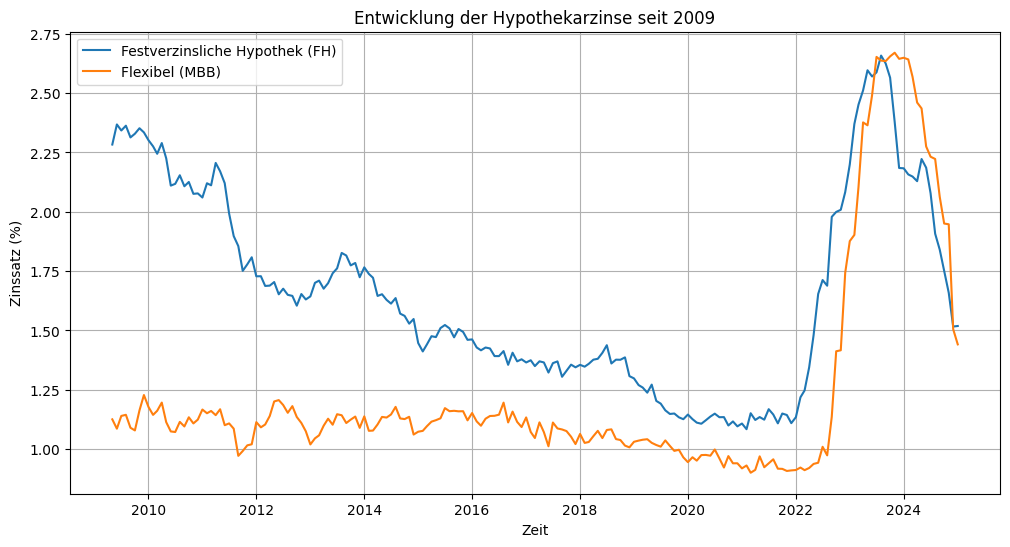

In [4]:
# Entwicklung der Zinssaetze ueber die Monate
plt.figure(figsize=(12,6))
plt.plot(df_pivot['Date'], zins_fh * 100, label='Festverzinsliche Hypothek (FH)')
plt.plot(df_pivot['Date'], zins_mbb * 100, label='Flexibel (MBB)')
plt.xlabel('Zeit')
plt.ylabel('Zinssatz (%)')
plt.title('Entwicklung der Hypothekarzinse seit 2009')
plt.legend()
plt.grid()
plt.show()

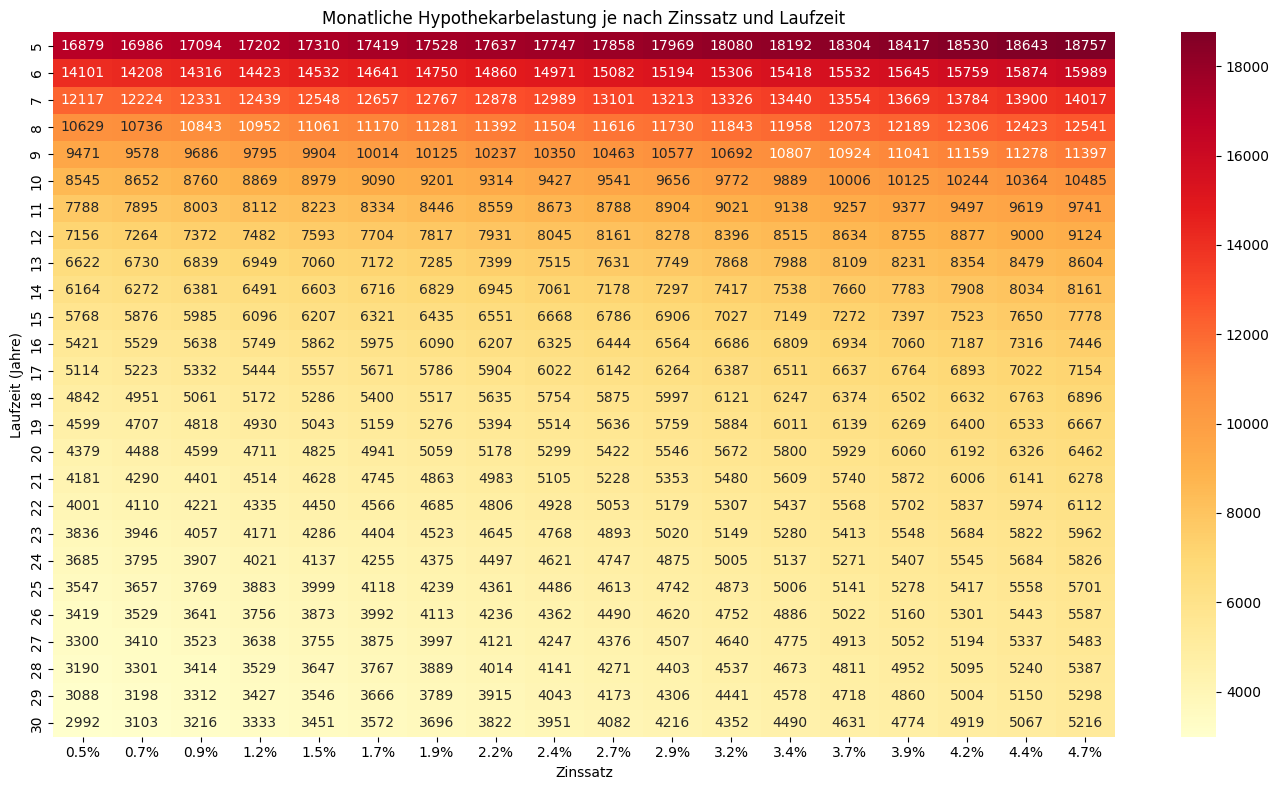

In [5]:
import seaborn as sns

# Annahmen
P = 1000000  # Kreditsumme in CHF

# Annuitaetenformel zur Monatsrate
def berechne_monatsrate(P, r, n):
    if r == 0:
        return P / n
    return P * r * (1 + r)**n / ((1 + r)**n - 1)

# Wertebereich fuer Heatmap
tzins = np.arange(0.005, 0.05, 0.0025)  # Zinssaetze von 0.5% bis 5%
laufzeiten = np.arange(5, 31, 1)  # Laufzeiten von 5 bis 30 Jahren

# Heatmap Datenmatrix erzeugen
heatmap_matrix = np.zeros((len(laufzeiten), len(tzins)))
for i, lz in enumerate(laufzeiten):
    for j, r in enumerate(tzins):
        monat_rate = berechne_monatsrate(P, r / 12, lz * 12)
        heatmap_matrix[i, j] = monat_rate

# Heatmap plotten
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_matrix,
    xticklabels=[f"{int(r*1000)/10:.1f}%" for r in tzins],
    yticklabels=[str(lz) for lz in laufzeiten],
    cmap="YlOrRd",
    annot=True,
    fmt=".0f"
)
plt.title("Monatliche Hypothekarbelastung je nach Zinssatz und Laufzeit")
plt.xlabel("Zinssatz")
plt.ylabel("Laufzeit (Jahre)")
plt.tight_layout()
plt.show()

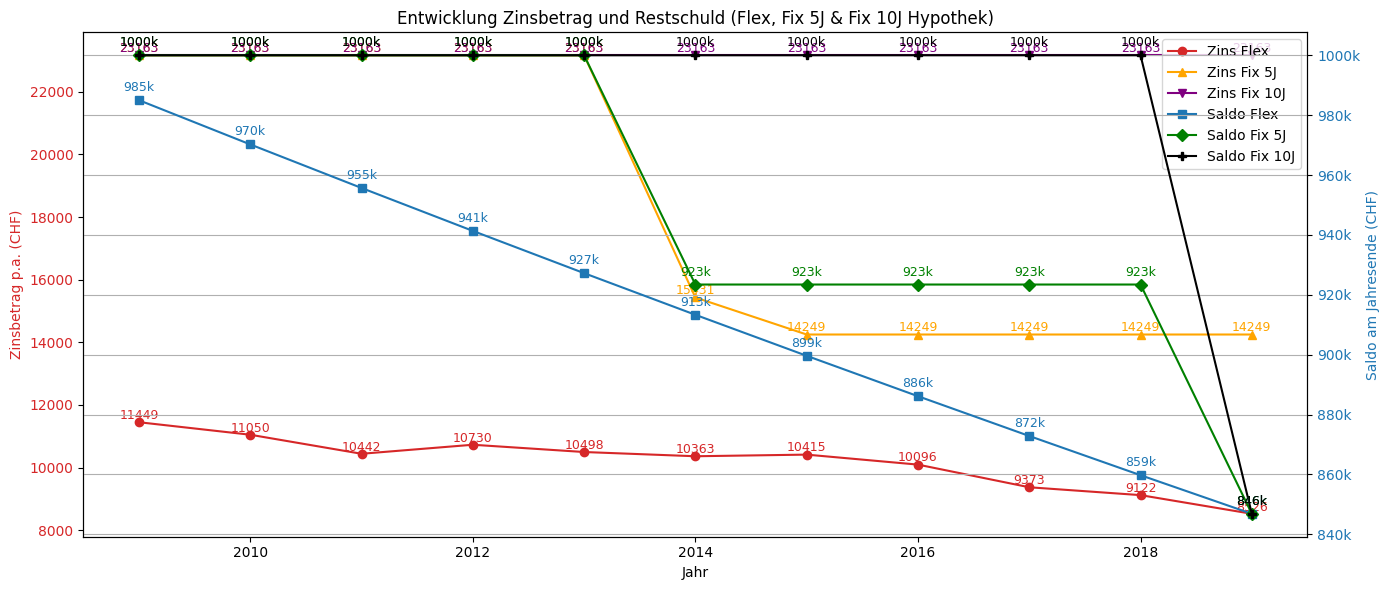


Zusammenfassung FLEX über 11 Jahre:
Total Tilgungen: 153,165 CHF
Total Zinszahlungen: 112,064 CHF
Total bezahlt: 265,229 CHF

Zusammenfassung FIX 5 Jahre über 11 Jahre:
Total Tilgungen: 153,164 CHF
Total Zinszahlungen: 202,491 CHF
Total bezahlt: 355,655 CHF

Zusammenfassung FIX 10 Jahre über 11 Jahre:
Total Tilgungen: 153,165 CHF
Total Zinszahlungen: 254,793 CHF
Total bezahlt: 407,958 CHF

Jährliche Übersicht:
 Jahr  Zins Flex  Zins Fix 5J  Zins Fix 10J  Tilgung Flex  Tilgung Fix 5J  Tilgung Fix 10J  Saldo Flex  Saldo Fix 5J  Saldo Fix 10J
 2009      11449        23163         23163         15000               0                0      985000       1000000        1000000
 2010      11050        23163         23163         14775               0                0      970225       1000000        1000000
 2011      10442        23163         23163         14553               0                0      955672       1000000        1000000
 2012      10730        23163         23163         14335

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Annahmen
P = 1000000  # Kreditsumme in CHF
laufzeit_jahre = 11

# FLEX-Variante
saldo_flex = P
daten_flex = []
for jahr in range(laufzeit_jahre):
    jahreszins = 0
    saldo_jahresbeginn = saldo_flex
    tilgung_jahr = saldo_jahresbeginn * 0.015
    for monat in range(12):
        zinssatz = zins_mbb.iloc[jahr * 12 + monat]
        zins_monat = saldo_flex * zinssatz / 12
        jahreszins += zins_monat
    saldo_flex -= tilgung_jahr
    daten_flex.append({
        'Jahr': 2009 + jahr,
        'Saldo am Jahresbeginn (CHF)': round(saldo_jahresbeginn),
        'Zinsbetrag Jahr (CHF)': round(jahreszins),
        'Tilgung (CHF)': round(tilgung_jahr),
        'Saldo am Jahresende (CHF)': round(saldo_flex)
    })

df_flex = pd.DataFrame(daten_flex)

# FIX 5 Jahre Variante mit identischer Gesamttilgung
saldo_fix5 = P
daten_fix5 = []

# Gesamttilgung Flex und fair aufteilen auf Jahr 5 und 10
totale_tilgung_flex = df_flex['Tilgung (CHF)'].sum()
tilgung_hälfte = totale_tilgung_flex / 2
zins_fix_jahr_1 = zins_fh.iloc[0:12].mean()
zins_fix_jahr_2 = zins_fh.iloc[60:72].mean() if len(zins_fh) >= 72 else zins_fh.iloc[-12:].mean()

for jahr in range(laufzeit_jahre):
    saldo_jahresbeginn = saldo_fix5
    tilgung_jahr = 0
    zinssatz = zins_fix_jahr_1 if jahr < 5 else zins_fix_jahr_2
    jahreszins = saldo_fix5 * zinssatz
    if jahr == 5 or jahr == 10:
        tilgung_jahr = tilgung_hälfte
        saldo_fix5 -= tilgung_jahr
    daten_fix5.append({
        'Jahr': 2009 + jahr,
        'Saldo am Jahresbeginn (CHF)': round(saldo_jahresbeginn),
        'Zinsbetrag Jahr (CHF)': round(jahreszins),
        'Tilgung (CHF)': round(tilgung_jahr),
        'Saldo am Jahresende (CHF)': round(saldo_fix5)
    })

df_fix5 = pd.DataFrame(daten_fix5)

# FIX 10 Jahre Variante mit identischer Gesamttilgung
saldo_fix10 = P
daten_fix10 = []
zins_fix10 = zins_fh.iloc[0:12].mean()

for jahr in range(laufzeit_jahre):
    saldo_jahresbeginn = saldo_fix10
    tilgung_jahr = 0
    jahreszins = saldo_fix10 * zins_fix10
    if jahr == 10:
        tilgung_jahr = totale_tilgung_flex
        saldo_fix10 -= tilgung_jahr
    daten_fix10.append({
        'Jahr': 2009 + jahr,
        'Saldo am Jahresbeginn (CHF)': round(saldo_jahresbeginn),
        'Zinsbetrag Jahr (CHF)': round(jahreszins),
        'Tilgung (CHF)': round(tilgung_jahr),
        'Saldo am Jahresende (CHF)': round(saldo_fix10)
    })

df_fix10 = pd.DataFrame(daten_fix10)

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Zinsbeträge
ax1.set_xlabel("Jahr")
ax1.set_ylabel("Zinsbetrag p.a. (CHF)", color='tab:red')
lns1 = ax1.plot(df_flex['Jahr'], df_flex['Zinsbetrag Jahr (CHF)'], marker='o', color='tab:red', label='Zins Flex')
lns2 = ax1.plot(df_fix5['Jahr'], df_fix5['Zinsbetrag Jahr (CHF)'], marker='^', color='orange', label='Zins Fix 5J')
lns3 = ax1.plot(df_fix10['Jahr'], df_fix10['Zinsbetrag Jahr (CHF)'], marker='v', color='purple', label='Zins Fix 10J')
for i, v in enumerate(df_flex['Zinsbetrag Jahr (CHF)']):
    ax1.text(df_flex['Jahr'][i], v + 100, f"{v}", ha='center', fontsize=9, color='tab:red')
for i, v in enumerate(df_fix5['Zinsbetrag Jahr (CHF)']):
    ax1.text(df_fix5['Jahr'][i], v + 100, f"{v}", ha='center', fontsize=9, color='orange')
for i, v in enumerate(df_fix10['Zinsbetrag Jahr (CHF)']):
    ax1.text(df_fix10['Jahr'][i], v + 100, f"{v}", ha='center', fontsize=9, color='purple')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Zweite Y-Achse für Restschuld
ax2 = ax1.twinx()
ax2.set_ylabel("Saldo am Jahresende (CHF)", color='tab:blue')
lns4 = ax2.plot(df_flex['Jahr'], df_flex['Saldo am Jahresende (CHF)'], marker='s', color='tab:blue', label='Saldo Flex')
lns5 = ax2.plot(df_fix5['Jahr'], df_fix5['Saldo am Jahresende (CHF)'], marker='D', color='green', label='Saldo Fix 5J')
lns6 = ax2.plot(df_fix10['Jahr'], df_fix10['Saldo am Jahresende (CHF)'], marker='P', color='black', label='Saldo Fix 10J')
for i, v in enumerate(df_flex['Saldo am Jahresende (CHF)']):
    ax2.text(df_flex['Jahr'][i], v + 3000, f"{v//1000}k", ha='center', fontsize=9, color='tab:blue')
for i, v in enumerate(df_fix5['Saldo am Jahresende (CHF)']):
    ax2.text(df_fix5['Jahr'][i], v + 3000, f"{v//1000}k", ha='center', fontsize=9, color='green')
for i, v in enumerate(df_fix10['Saldo am Jahresende (CHF)']):
    ax2.text(df_fix10['Jahr'][i], v + 3000, f"{v//1000}k", ha='center', fontsize=9, color='black')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

# Legende zusammenführen
lns = lns1 + lns2 + lns3 + lns4 + lns5 + lns6
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

plt.title("Entwicklung Zinsbetrag und Restschuld (Flex, Fix 5J & Fix 10J Hypothek)")
fig.tight_layout()
plt.grid(True)
plt.show()

# Totalsummen Flex
summe_tilg_flex = df_flex['Tilgung (CHF)'].sum()
summe_zins_flex = df_flex['Zinsbetrag Jahr (CHF)'].sum()
gesamt_flex = summe_tilg_flex + summe_zins_flex
print("\nZusammenfassung FLEX über 11 Jahre:")
print(f"Total Tilgungen: {round(summe_tilg_flex):,} CHF")
print(f"Total Zinszahlungen: {round(summe_zins_flex):,} CHF")
print(f"Total bezahlt: {round(gesamt_flex):,} CHF")

# Totalsummen Fix 5 Jahre
summe_tilg_fix5 = df_fix5['Tilgung (CHF)'].sum()
summe_zins_fix5 = df_fix5['Zinsbetrag Jahr (CHF)'].sum()
gesamt_fix5 = summe_tilg_fix5 + summe_zins_fix5
print("\nZusammenfassung FIX 5 Jahre über 11 Jahre:")
print(f"Total Tilgungen: {round(summe_tilg_fix5):,} CHF")
print(f"Total Zinszahlungen: {round(summe_zins_fix5):,} CHF")
print(f"Total bezahlt: {round(gesamt_fix5):,} CHF")

# Totalsummen Fix 10 Jahre
summe_tilg_fix10 = df_fix10['Tilgung (CHF)'].sum()
summe_zins_fix10 = df_fix10['Zinsbetrag Jahr (CHF)'].sum()
gesamt_fix10 = summe_tilg_fix10 + summe_zins_fix10
print("\nZusammenfassung FIX 10 Jahre über 11 Jahre:")
print(f"Total Tilgungen: {round(summe_tilg_fix10):,} CHF")
print(f"Total Zinszahlungen: {round(summe_zins_fix10):,} CHF")
print(f"Total bezahlt: {round(gesamt_fix10):,} CHF")


# Gemeinsame Jahrestabelle
df_vergleich = df_flex[['Jahr']].copy()
df_vergleich['Zins Flex'] = df_flex['Zinsbetrag Jahr (CHF)']
df_vergleich['Zins Fix 5J'] = df_fix5['Zinsbetrag Jahr (CHF)']
df_vergleich['Zins Fix 10J'] = df_fix10['Zinsbetrag Jahr (CHF)']
df_vergleich['Tilgung Flex'] = df_flex['Tilgung (CHF)']
df_vergleich['Tilgung Fix 5J'] = df_fix5['Tilgung (CHF)']
df_vergleich['Tilgung Fix 10J'] = df_fix10['Tilgung (CHF)']
df_vergleich['Saldo Flex'] = df_flex['Saldo am Jahresende (CHF)']
df_vergleich['Saldo Fix 5J'] = df_fix5['Saldo am Jahresende (CHF)']
df_vergleich['Saldo Fix 10J'] = df_fix10['Saldo am Jahresende (CHF)']

print("\nJährliche Übersicht:")
print(df_vergleich.to_string(index=False))


Eigenkapitalquote und Tragbarkeit
Eigenkapitalquote: 20.00%
Jährliche Belastung (Zins, Amortisation, Nebenkosten): 72,500 CHF
Tragbarkeit (max. 33% empfohlen): 29.00%

Investitionsrechnung nach 10 Jahren:
Aktien (6% p.a.): 447,712 CHF
Anleihen (2% p.a.): 304,749 CHF
Sparkonto (0.5% p.a.): 262,785 CHF


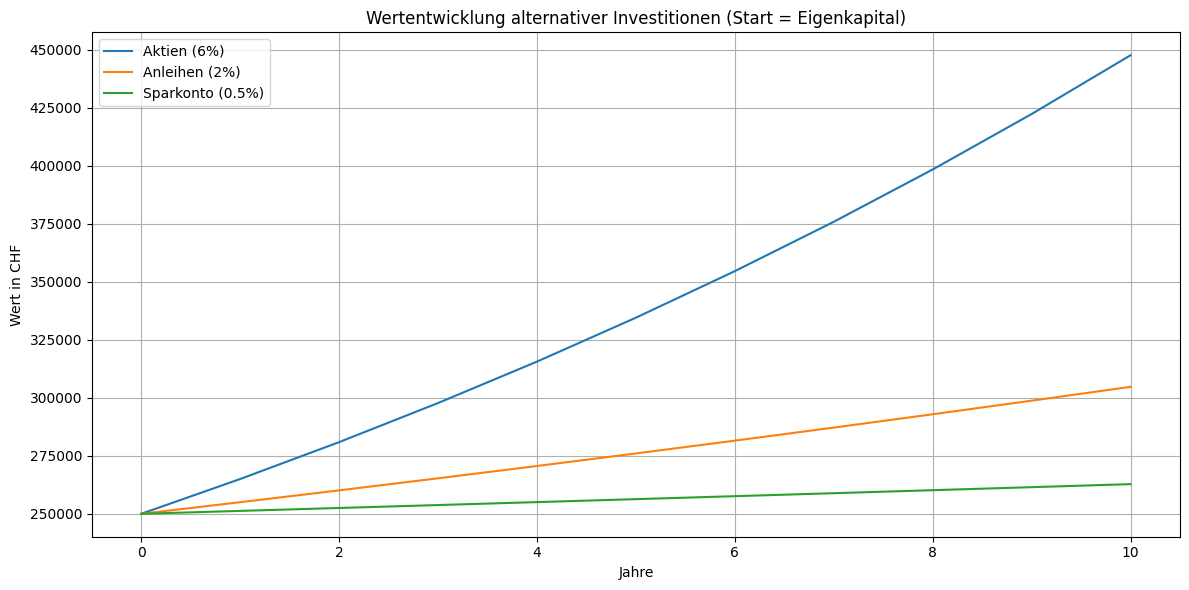

In [8]:
# Eigenkapitalquote und Tragbarkeit
hypothek = 1000000
kaufpreis_immobilie = 1250000  # Beispiel: 80% Fremdkapital

eigenkapital = kaufpreis_immobilie - hypothek
quote = eigenkapital / kaufpreis_immobilie
tragbarkeitseinkommen = 250000  # CHF pro Jahr

# Formel: Eigenkapitalquote = Eigenkapital / Kaufpreis
# Formel: Tragbarkeit = (Zins + Amortisation + Nebenkosten) / Einkommen <= 33%

zins_annahme = 0.05 * hypothek  # 5% kalkulatorischer Zins
amortisation = hypothek * 0.01  # 1% Amortisation
nebenkosten = kaufpreis_immobilie * 0.01  # 1% Nebenkosten
jahresbelastung = zins_annahme + amortisation + nebenkosten
tragbarkeit = jahresbelastung / tragbarkeitseinkommen

print("\nEigenkapitalquote und Tragbarkeit")
print(f"Eigenkapitalquote: {quote:.2%}")
print(f"Jährliche Belastung (Zins, Amortisation, Nebenkosten): {round(jahresbelastung):,} CHF")
print(f"Tragbarkeit (max. 33% empfohlen): {tragbarkeit:.2%}")

# Investitionsrechnung
anlagebetrag = eigenkapital
jahre = 10
rendite_aktien = 0.06
rendite_anleihen = 0.02
rendite_sparkonto = 0.005

def endwert(startwert, zins, jahre):
    return startwert * (1 + zins) ** jahre

wert_aktien = endwert(anlagebetrag, rendite_aktien, jahre)
wert_anleihen = endwert(anlagebetrag, rendite_anleihen, jahre)
wert_sparen = endwert(anlagebetrag, rendite_sparkonto, jahre)

print("\nInvestitionsrechnung nach 10 Jahren:")
print(f"Aktien (6% p.a.): {round(wert_aktien):,} CHF")
print(f"Anleihen (2% p.a.): {round(wert_anleihen):,} CHF")
print(f"Sparkonto (0.5% p.a.): {round(wert_sparen):,} CHF")

# Plot der Investitionsentwicklung
jahre_liste = list(range(jahre + 1))
werte_aktien = [endwert(anlagebetrag, rendite_aktien, j) for j in jahre_liste]
werte_anleihen = [endwert(anlagebetrag, rendite_anleihen, j) for j in jahre_liste]
werte_sparen = [endwert(anlagebetrag, rendite_sparkonto, j) for j in jahre_liste]

plt.figure(figsize=(12,6))
plt.plot(jahre_liste, werte_aktien, label='Aktien (6%)')
plt.plot(jahre_liste, werte_anleihen, label='Anleihen (2%)')
plt.plot(jahre_liste, werte_sparen, label='Sparkonto (0.5%)')
plt.xlabel("Jahre")
plt.ylabel("Wert in CHF")
plt.title("Wertentwicklung alternativer Investitionen (Start = Eigenkapital)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Parameter
startkapital = 250000
jahre = 10

rendite_aktien = 0.06
rendite_anleihen = 0.02
rendite_sparen = 0.005

# Immobilienannahmen
kaufpreis = 1250_000
zinskosten = 113194
nebenkosten = 91250
wertzuwachs_rate = 0.028

# Alternativen berechnen
def endwert(startwert, zins, jahre):
    return startwert * (1 + zins) ** jahre

wert_aktien = round(endwert(startkapital, rendite_aktien, jahre))
wert_anleihen = round(endwert(startkapital, rendite_anleihen, jahre))
wert_sparen = round(endwert(startkapital, rendite_sparen, jahre))

# Immobilie nach 10 Jahren
immobilien_endwert = round(kaufpreis * (1 + wertzuwachs_rate) ** jahre)
immobilien_gewinn = immobilien_endwert - zinskosten - nebenkosten - kaufpreis
immobilie_total = round(startkapital + immobilien_gewinn)

# Ausgabe
print("Vergleich zu alternativen Investitionen:")
print(f"Aktien (6% p.a.): {wert_aktien:,} CHF")
print(f"Anleihen (2% p.a.): {wert_anleihen:,} CHF")
print(f"Sparkonto (0.5% p.a.): {wert_sparen:,} CHF")
print(f"Immobilie (abz. Kosten): {immobilie_total:,} CHF")


Vergleich zu alternativen Investitionen:
Aktien (6% p.a.): 447,712 CHF
Anleihen (2% p.a.): 304,749 CHF
Sparkonto (0.5% p.a.): 262,785 CHF
Immobilie (abz. Kosten): 443,116 CHF
